## ML6 Notebook

In the video, you learnt what a linear classifier is, and how its parameters can be learnt.

We will work through creating and training a linear classifier in Python for the custom iris set we created. **This is the longest, and probably the most important notebook!**

Recall that our custom iris dataset consists of 100 4D data points labelled as either **versicolor (0)** or **virginica (1)**. 40 of these points form the training set, 20 form validation, and 40 form test.

Formally, our training set is $\{\mathbf{{x}}_{i}\}_{i=1}^{N}$ ($N=40$) where each $\mathbf{x}_i\in \mathbb{R}^{4}$. Each datum has an associated label $y_i\in \{0, 1\}$ where $0$ corresponds to versicolor, and $1$ corresponds to virginica.

In [1]:
import numpy as np # Import numpy


def load_iris():
    """
    This function loads in all our dataset splits.
    """
    D = np.load('iris_splits.npz')
    return D['X_train'], D['y_train'], D['X_val'], D['y_val'], D['X_test'], D['y_test']

X_train, y_train, X_val, y_val, X_test, y_test = load_iris()

### Creating a linear classifier

Let's start by creating a class to represent our classifier. As we are in 4D, our classifier will have a weight vector $\mathbf{w}\in \mathbb{R}^{4}$, and a bias $b\in \mathbb{R}^{1}$. We will initialise these at random. We will not absorb the bias for clarity.

In [2]:
np.random.seed(5) # Fix the seed so we have the same random numbers each time we run this.

class LinearClassifier:
    """
    This class creates a linear classifer object with randomly initialised weight and bias.
    Its apply function can be used to apply the classifier to a data point.
    """
    def __init__(self, num_dimensions=4):
        self.w = np.random.normal(size=num_dimensions) # Create a weight vector 
        self.b = np.random.normal(size=1) # Create a bias
        
    def apply(self, x):
        """
        This function takes in a data point x, and applies the classifier to it.
        """
        return x@self.w.T + self.b # Computes the classifier output

Let's make a classifier object from this class, and apply it to a dummy data point. Remember that a linear classifier takes a data point $\mathbf{x}_i$ and outputs

$$z_i = \mathbf{x}_i\mathbf{w}^\top + b$$ 

where $z_i\in \mathbb{R}^{1}$.

In [3]:
classifier = LinearClassifier() # Make classifier
x_i = np.array([1,2,3,4]) # Create a dummy data point. Remember we are working in 4D
z_i = classifier.apply(x_i) # Apply classifier to data point.
print(z_i)

[6.17304207]


### Training a classifier

A classifier isn't very useful with random parameters, so we are going to learn these by training the classifier with a training set.

To do this we need 

- to devise a loss function, that is **small** when our classifier does what we want it to do 
- an optimisation algorithm to minimise that loss function

Following the video, we are going to use the **Mean Squared Error (MSE) loss** where want a classifier to output $z_i=1$ if $y_i=1$ and $z_i=0$ if $y_i=0$ for each training point.

$$L = \frac{1}{N}\sum_{i=1}^N (z_i - y_i)^2 = \frac{1}{N}\sum_{i=1}^N (\mathbf{x}_i \mathbf{w}^\top + b - y_i)^2$$

Let's compute the MSE loss for our randomly initalised classifier.

First, let's get the classifier outputs for our training data. The way we have written the `apply` function means we can apply the classifier to the whole training set in one go, in parallel.

In [4]:
outputs = classifier.apply(X_train) # Apply the classifier to the training set
print(outputs) 

[ 2.71291564  0.55332369  0.72863524  1.23264337  2.75705781  1.75422019
  0.16450055  1.26631083  0.88625247  0.81937071  2.23414059  1.77030467
  2.87350859  1.14678558  1.93609405  0.83444717  0.77527009  4.31085347
  1.25110918  2.47026795  2.62596991  0.88466739  2.25496317  0.65534408
  1.2451126   1.6125761   1.91926577  1.4921718   4.7302972   2.57945594
  1.34600529  1.4714584   1.73184239  2.18525816 -0.87644074  2.82299954
  5.09227622  2.99253792  0.74913974  1.36808592]


Now let's write a function that computes MSE.

In [5]:
def get_loss(outputs, labels):
    """
    This function takes classifier outputs for data points, and the true labels to compute MSE.
    """
    return np.mean((outputs-labels)**2)

loss = get_loss(outputs, y_train)
print(loss)

2.632312885355284


For the classifier to do what we want it to do, we want this MSE to be as low as possible.

We will use an **optimisation algorithm** to find the **classifier parameters that minimise this loss function**.

### Gradient Descent

Given a loss function $L$ that is a function of some parameter vector $\mathbf{w}$, we can minimise $L$ using the gradient descent algorithm.

<img src="./grad.png" title="grad"/>

Let our initial parameter vector be $\mathbf{w}_{t=0}$. The gradient of the loss with respect to this vector $\frac{\partial L}{\partial \mathbf{w}_{t=0}}$ is, locally, the vector that points in the direction that we can move $\mathbf{w}_{t=0}$ in to most **increase** the loss.

We want to decrease the loss, so we need to move $\mathbf{w}_{t=0}$ in the **opposite direction**.

To do this, we subtract this vector (multiplied by a constant $\alpha$) from $\mathbf{w}_{t=0}$:

$$\mathbf{w}_{t=1} = \mathbf{w}_{t=0} - \alpha \frac{\partial L}{\partial \mathbf{w}_{t=0}}$$

$\alpha$ is a hyper-parameter called the learning rate, which is typically set to a small value.

We then repeat this process using $\frac{\partial L}{\partial \mathbf{w}_{t=1}}$ to compute $\mathbf{w}_{t=2}$, and so on until we have made our loss as small as possible.

What do we do about $b$? We initialise it as $b_{t=0}$ and update it alongside $\mathbf{w}$ by computing $\frac{\partial L}{\partial b_t}$ at each step, and adjusting it in a similar way.



### What are these gradients?



We can write expressions for these gradients ourselves analytically, and then plug these into Python.

Recall that we have 
$$L = \frac{1}{N}\sum_{i=1}^N (z_i - y_i)^2 = \frac{1}{N}\sum_{i=1}^N (\mathbf{x}_i \mathbf{w}^\top + b - y_i)^2$$

Computing $\frac{\partial L}{\partial b}$ is quite straightforward if you remember that differentiation and summation are both **linear** which means we can swap their order.

$$L  = \frac{1}{N}\sum_{i=1}^N (\mathbf{x}_i \mathbf{w}^\top + b - y_i)^2$$

$$\frac{\partial L}{\partial b}  = \frac{\partial}{\partial b}\big(\frac{1}{N}\sum_{i=1}^N (\mathbf{x}_i \mathbf{w}^\top + b - y_i)^2\big)$$

$$\frac{\partial L}{\partial b}  = \frac{1}{N}\sum_{i=1}^N \frac{\partial}{\partial b}\big((\mathbf{x}_i \mathbf{w}^\top + b - y_i)^2\big)$$

$$\frac{\partial L}{\partial b}  = \frac{2}{N}\sum_{i=1}^N(\mathbf{x}_i \mathbf{w}^\top + b - y_i) = \frac{2}{N}\sum_{i=1}^N(z_i - y_i)$$

Computing $\frac{\partial L}{\partial \mathbf{w}}$ is more challenging. In the slides, I wrote this vector out in terms of its elements

$$\frac{\partial L}{\partial {\mathbf{w}}} =
\begin{bmatrix}
\frac{\partial L}{\partial {w_1}}&\frac{\partial L}{\partial {w_2}}&... \\
\end{bmatrix}$$

While it is possible to individually compute each of the derivative elements separately, I will instead turn to a result from vector calculus.

$$\frac{d}{d\mathbf{w}}(\mathbf{x}\mathbf{w}^\top)= \mathbf{x}$$

Armed with this, we can compute $\frac{\partial L}{\partial \mathbf{w}}$:

$$L  = \frac{1}{N}\sum_{i=1}^N (\mathbf{x}_i \mathbf{w}^\top + b - y_i)^2$$

$$\frac{\partial L}{\partial \mathbf{w}}  = \frac{1}{N}\sum_{i=1}^N \frac{\partial}{\partial \mathbf{w}}\big((\mathbf{x}_i \mathbf{w}^\top + b - y_i)^2\big)$$

$$\frac{\partial L}{\partial \mathbf{w}}   = \frac{2}{N}\sum_{i=1}^N\mathbf{x}_i (\mathbf{x}_i \mathbf{w}^\top + b - y_i) = \frac{2}{N}\sum_{i=1}^N \mathbf{x}_i  (z_i - y_i)$$

### Performing Gradient Descent

Now that we have expressions for the gradients, we are going to write some code to perform gradient descent.



In [6]:
def train_classifier_using_GD(classifier, X_train, y_train, alpha = 0.1, num_iters = 100):
    """
    This function takes in a classifier object, training data, labels, and a learning
    rate alpha and performs iterations of gradient descent to update the classifier's
    parameters. It uses the gradients of the MSE loss. The function will change the
    parameter weights of the classifier object, and outputs the MSE loss for each iteration.
    Args:
        classifier : A classifier object as defined above in this notebook.
        X_train : training set represented by a matrix (NxD) of N data points of dimensionality D
        y_train : labels for the training set, a vector N where each element i corresponds to the label of X_train[i]
        alpha : The learning rate, default 0.1
        num_iters : The number of iterations to perform gradient descent, default 100
    Example use:
        >>> loss_array = train_classifier_using_GD(classifier, X_train, y_train)
    """
    
    num_data_points, num_dimensions = X_train.shape # Get num data points, and dims
    loss_array = [] # Empty array to append the MSE loss at each iteration.
    
    for _ in range(num_iters):
        
        z = classifier.apply(X_train) # Apply the classifier to the training points
         
        dL_dw =  np.zeros(num_dimensions) # Create a zero array to populate
        dL_db = 0 # Zero value for bias
        
        for i in range(num_data_points):
            dL_dw += X_train[i]*(z[i]-y_train[i]) # Sum for each data point
            dL_db += (z[i]-y_train[i]) # Sum for each data point

        dL_dw *= 2/num_data_points # Multiply by 2/N
        dL_db *= 2/num_data_points # Multiply by 2/N
        
        # Now, update the parameters
        classifier.w -= alpha * dL_dw 
        classifier.b -= alpha * dL_db
        
        # (Re)compute loss and append to loss array
        z = classifier.apply(X_train) 
        loss = np.mean((z-y_train)**2)
        loss_array.append(loss)

    return loss_array
        
            
loss_array = train_classifier_using_GD(classifier, X_train, y_train) # Perform gradient descent to learn our classifier!

We have now performed 100 iterations of gradient descent to train our classifier (i.e. adjust its parameters so that MSE loss is minimised).

The code above records the loss after each iteration. Let's see how it changed as we iterated:

Text(0, 0.5, 'Loss')

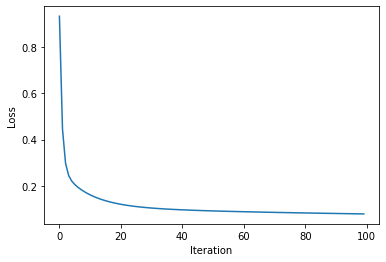

In [7]:
import matplotlib.pyplot as plt # Plotting code
plt.plot(loss_array)
plt.xlabel('Iteration')
plt.ylabel('Loss')

We can see that performing gradient descent has continuously updated the parameters of our classifier to make the loss small! Now that we have learnt our classifier, let's apply it to the test set and see how accurate it is.

As per the slides, we will count the classifier prediction as being for class 0 (veriscolor) if its output is less than 0.5, and being for class 1 (virginica) if it is greater than 0.5.

In [9]:
def compute_accuracy(outputs, true_labels):
    """
    Compares predicted labels in predictions to the actual labels in true_labels and computes an accuracy score.
    Args:
        predictions : an N-D array of predictions obtained from a classifier for some data points
        true_labels : an N-D array of ground-truth labels 
    Example use:
        >>> val_accuracy = compute_accuracy(val_predictions, y_val)
        >>> test_accuracy = compute_accuracy(test_predictions, y_test)
    """
    predictions = np.zeros_like(outputs)
    for i in range(len(outputs)):
        if outputs[i] > 0.5: # Classify as 1 if >0.5 and as 0 if <0.5
            predictions[i] = 1
        else:
            predictions[i] = 0

    return 100*np.sum(predictions==true_labels)/len(predictions)


outputs = classifier.apply(X_test) # Apply learnt classifier to test points to get predictions
acc = compute_accuracy(outputs, y_test) # See if the predictions were accurate.
print(f'Our trained linear classifier is {acc:0.2f}% accurate.')

Our trained linear classifier is 92.50% accurate.
